# **Book Description Models**

# Loading in and Understanding the Data

In [ ]:
#----------------- IMPORT STATEMENTS -----------------#

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import gzip
import pickle
import nltk
import re
import tensorflow as tf

from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping as ES
from keras.callbacks import ModelCheckpoint as MC
from keras.callbacks import TensorBoard as TB
from keras.layers import Dropout


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:

#----------------- SET UP DRIVE AND GET DATA -----------------#

# Load from Google Drive
drive.mount('/content/gdrive')

# Load the full data 
all_data = pd.read_csv('gdrive/MyDrive/books_clean.csv.gz', compression='gzip')


Mounted at /content/gdrive


In [ ]:
#----------------- SET UP DRIVE AND GET DATA -----------------#

# takes the original data and filters for description and encodes the genres
def reset_description_data(all_data):
  # Filter for records with descriptions
  desc_df = all_data[all_data['description'] == all_data['description']]

  # Create a label encoder
  le = LabelEncoder()

  # Label encode the genres and get the encoding list

  desc_df.loc[:,'genre_1'] = le.fit_transform(desc_df['first'])
  map1 = list(le.classes_)
  desc_df.loc[:,'genre_2'] = le.fit_transform(desc_df['genre_cleaned'])
  map2 = list(le.classes_)
  desc_df.loc[:,'genre_3'] = le.fit_transform(desc_df['genre_cleaned2'])
  map3 = list(le.classes_)
  desc_df.loc[:,'genre_4'] = le.fit_transform(desc_df['genre_cleaned3'])
  map4 = list(le.classes_)

  return desc_df, map1, map2, map3, map4

We note that our dataset has 1,457,175 values and out of that, 1,233,578 have book descriptions.  Our dataset can be visualized as found below.  

In [ ]:
desc_data, genre_dict_1, genre_dict_2, genre_dict_3, genre_dict_4 = reset_description_data(all_data)

print("TOTAL RECORDS: ", len(all_data))
print("TOTAL WITH DESCRIPTIONS: ", len(desc_data))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


TOTAL RECORDS:  1457175
TOTAL WITH DESCRIPTIONS:  1233578


In [ ]:
desc_data.head(2)

,Unnamed: 0,isbn,average_rating,description,link,authors,publisher,num_pages,isbn13,publication_year,...,first,second,third,genre_cleaned,genre_cleaned2,genre_cleaned3,genre_1,genre_2,genre_3,genre_4
1,1,0743509986,3.23,"Anita Diamant's international bestseller ""The ...",https://www.goodreads.com/book/show/1333909.Go...,626222.0,Simon & Schuster Audio,NaN,9780743509985,2001.0,...,fiction,"history, historical fiction, biography",NaN,"history, historical fiction, biography","fiction: history, historical fiction, biography","fiction: history, historical fiction, biography",3,4,7,7
2,2,NaN,4.03,Omnibus book club edition containing the Ladie...,https://www.goodreads.com/book/show/7327624-th...,10333.0,"Nelson Doubleday, Inc.",600.0,NaN,1987.0,...,"fantasy, paranormal",fiction,"mystery, thriller, crime","fantasy, paranormal","fantasy, paranormal","fiction: fantasy, paranormal",2,2,2,6


# Initial Cleaning: Nondescript Descriptions and Oversampling

We can clearly see that the top 5 book descriptions are not book-specific at all and will probably not help determine book genre.  Overall, there are 1470 records attributed to these descriptions. Lets take a closer look and filter those out to have 1,232,108 final rows.

In [ ]:
n_top_desc = 10
top_10_desc = desc_data['description'].value_counts()[:n_top_desc].index.tolist()
top_10_desc

['This book was converted from its physical edition to the digital format by a community of volunteers. You may find it for free on the web. Purchase of the Kindle edition includes wireless delivery.',
 'This is a pre-1923 historical reproduction that was curated for quality. Quality assurance was conducted on each of these books in an attempt to remove books with imperfections introduced by the digitization process. Though we have made best efforts - the books may have occasional errors that do not impede the reading experience. We believe this work is culturally important and have elected to bring the book back into print as part of our continuing commitment to the preservation of printed works worldwide.',
 'Many of the earliest books, particularly those dating back to the 1900s and before, are now extremely scarce and increasingly expensive. We are republishing these classic works in affordable, high quality, modern editions, using the original text and artwork.',
 'This work has b

In [ ]:
desc_data = desc_data.loc[desc_data['description'].isin(top_10_desc[:5])==False]

We have also found significant class imbalance (see the book title ipynb).  To combat this, we will see if oversampling will improve our model performance.  Lets make an oversampled dataset.  This will take us from 1,232,108 records up to 2,241,730.  We define some helper functions so we can keep track in the future of our edits to the data. 

In [ ]:
def get_genre(data, genre):
  return data[['book_id', 'description', genre]]

In [ ]:
def oversample_dataset(data, label):
  c_size = dict(Counter(data[label]))
  max_val = max(c_size.values())
  oversampling_list = []

  for i in data[label].unique():
    oversampling_list.extend(data[data[label] == i].sample(max_val, replace = True)['book_id'])
  df_over = pd.DataFrame({'book_id': oversampling_list})
  df_over = df_over.merge(data, on='book_id', how='left')
  return df_over

In [ ]:
def get_train_test(data, genre, over):
  df_genre = get_genre(data, genre)
  # set oversampled to -1 unless we want the oversampled data
  if over > 0:
      df_genre = oversample_dataset(df_genre, genre)
  X = df_genre['description']
  y = df_genre[genre]

  # Get train and test
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  cv = CountVectorizer(analyzer = 'word',ngram_range=(1,1), stop_words='english')
  X_train_cv = cv.fit_transform(X_train)
  X_test_cv = cv.transform(X_test)

  return X_train_cv, X_test_cv, y_train, y_test 

In [ ]:
#----------------- HELPER FUNCTIONS -----------------#

def set_x_y(data, X_column, y_column):
  X = data[X_column]
  y = data[y_column]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test
def set_x_y_clean(data, desc, y_column):
  X = desc
  y = data[y_column]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test
def reset_data(all_data):
  filter_for_descriptions = all_data[all_data['description'] == all_data['description']]
  le = LabelEncoder()
  filter_for_descriptions['genre_1'] = le.fit_transform(filter_for_descriptions['first'])
  filter_for_descriptions['genre_2'] = le.fit_transform(filter_for_descriptions['genre_cleaned'])
  filter_for_descriptions['genre_3'] = le.fit_transform(filter_for_descriptions['genre_cleaned2'])
  filter_for_descriptions['genre_4'] = le.fit_transform(filter_for_descriptions['genre_cleaned3'])
  return filter_for_descriptions

In [ ]:
def get_train_test2(data, genre, over):
  df_genre = get_genre(data, genre)
  # set oversampled to -1 unless we want  the oversampled data
  if over > 0:
      df_genre = oversample_dataset(df_genre, genre)
  X = df_genre['description']
  y = df_genre[genre]

  # Get train and test  
  cv = CountVectorizer(analyzer = 'word',ngram_range=(1,1), stop_words='english')
  CV = cv.fit_transform(X)
  X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(CV, y)

  return X_train_cv, X_test_cv, y_train_cv, y_test_cv, CV, y, cv

# A Weak Baseline: Majority Class Classifier

In [ ]:
majority_class = desc_data['genre_1'].value_counts().idxmax()
print("Our majority class is ", majority_class, ' which is ', genre_dict_1[majority_class])

# gets train test split for data according to genre 1, not oversampled
X_train, X_test, y_train, y_test = get_train_test(desc_data, 'genre_1', -1)

Our majority class is  3  which is  fiction


In [ ]:
y_pred_majority = np.full((len(y_test)),majority_class)
score_majority = f1_score(y_test, y_pred_majority, average='micro')
print('MAJORITY CLASS F1 SCORE: ', np.round(score_majority,4))

MAJORITY CLASS F1 SCORE:  0.2078


# Simple Bag of Words for Naive Bayes

Lets test a simple bag of words using naive bayes.  We will split into train/test data, use a CountVectorizer, and test both the normal and oversampled data.  Lets see our initial results. 


In [ ]:
y_genres = ['genre_1','genre_2','genre_3','genre_4']
for genre in y_genres:
  print('-------------- ', genre, ' --------------')
  # Get train and test, both oversampled and normal
  X_train, X_test, y_train, y_test = get_train_test(desc_data, genre, -1)

  # train naive bayes classifier
  clf = MultinomialNB()
  clf.fit(X_train, y_train)

  # create predictions for not oversampled data and print f1 score
  y_pred_train = clf.predict(X_train)
  y_pred_test = clf.predict(X_test)
  score_train = f1_score(y_train, y_pred_train, average='micro')
  score_test = f1_score(y_test, y_pred_test, average='micro')
  print('NORMAL -- \tF-1 train: ', np.round(score_train,4), ' F-1 test: ', np.round(score_test,4))



--------------  genre_1  --------------
NORMAL -- 	F-1 train:  0.7343  F-1 test:  0.7082
--------------  genre_2  --------------
NORMAL -- 	F-1 train:  0.7351  F-1 test:  0.7102
--------------  genre_3  --------------
NORMAL -- 	F-1 train:  0.6957  F-1 test:  0.6658
--------------  genre_4  --------------
NORMAL -- 	F-1 train:  0.6341  F-1 test:  0.589


In [ ]:
genre = 'first'
X_train_oversampled, X_test_oversampled, y_train_oversampled, y_test_oversampled, X_cv, y_cv, cv_vect = get_train_test2(desc_data, genre, 1)

# train model to create prediction for oversampled data and print f1 score
clf = MultinomialNB()
clf.fit(X_train_oversampled, y_train_oversampled)
y_pred_train_over = clf.predict(X_train_oversampled)
y_pred_test_over = clf.predict(X_test_oversampled)
score_train_over = f1_score(y_train_oversampled, y_pred_train_over, average='micro')
score_test_over = f1_score(y_test_oversampled, y_pred_test_over, average='micro')
print('OVERSAMPLED -- \tF-1 train: ', np.round(score_train_over,4), ' F-1 test: ', np.round(score_test_over,4))

OVERSAMPLED -- 	F-1 train:  0.7687  F-1 test:  0.7577


In [ ]:
filename = 'nb_oversampled_updated_train_test.sav'
pickle.dump(clf, open(filename, 'wb'))

Lets grab the predictions from this Naive Bayes model to test our ensemble classifier later!  We can also visualize how Naive Bayes did over the testing data.  Note these are all for the oversampled data!  First we show how our model performed on the oversampled data using sklearn's classification_report.  Then we transform the descriptions into vectors and predict those, we will hopefully utilize these in an ensemble method! Over all the data, not just the test data, the model performs at 0.72 as an f1 score.  Lets see if we can improve this!

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_oversampled, y_pred_test_over, target_names=genre_dict_1))

                                        precision    recall  f1-score   support

                              children       0.80      0.81      0.81     63616
                       comics, graphic       0.90      0.75      0.82     63705
                   fantasy, paranormal       0.71      0.74      0.72     63274
                               fiction       0.64      0.55      0.59     63615
history, historical fiction, biography       0.72      0.67      0.69     64136
              mystery, thriller, crime       0.78      0.83      0.81     63376
                           non-fiction       0.75      0.69      0.72     63280
                                poetry       0.85      0.90      0.88     63665
                               romance       0.71      0.85      0.77     63414
                           young-adult       0.74      0.79      0.76     63997

                              accuracy                           0.76    636078
                             macro avg

In [ ]:
nb_all = cv_vect.transform(desc_data['description'])

In [ ]:
nb_all_pred = clf.predict(nb_all)

In [ ]:
df_nb_final = pd.DataFrame(list(zip(desc_data['book_id'], nb_all_pred, desc_data['first'])),
               columns =['bid', 'nb_predictions', 'true_label'])
df_nb_final.to_csv('all_nb_desc_final_predictions.csv')

# LSTM

## Lets try to clean the descriptions a little bit...

We can clearly see genre_3 and genre_4 perform worse than genre_1 and genre_2.  Lets clean the data a bit.  First lets look at how long the book descriptions generally are. Overall, we can see in the histogram below that almost every book description is less than 500 words.  And the vast majority are below 250 words.

In [ ]:
desc_data, genre_dict_1, genre_dict_2, genre_dict_3, genre_dict_4 = reset_description_data(all_data)
desc_1 = get_genre(desc_data, 'genre_1')
desc_2 = get_genre(desc_data, 'genre_2')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<function matplotlib.pyplot.show>

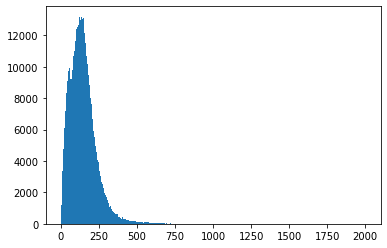

In [ ]:
desc_data['desc_len'] = [len(i.split()) for i in desc_data.description]
sdl = sorted(desc_data['desc_len'])
_ = plt.hist(sdl, 1000, range=[0, 2000])
plt.show

Lets make the descriptions lowercase, remove stop words, and lemmatize. 

In [ ]:
desc_1["description"] = desc_1["description"].str.lower() 
desc_1.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,book_id,description,genre_1
1,1333909,"anita diamant's international bestseller ""the ...",3
2,7327624,omnibus book club edition containing the ladie...,2
3,6066819,addie downs and valerie adler were eight when ...,3


In [ ]:
descriptions = desc_1['description']
desc = []
wordnet_lemmatizer = WordNetLemmatizer()
#snowball_stemmer = SnowballStemmer('english')
import re 
from nltk import word_tokenize
nltk.download('punkt')

for i,text in enumerate(descriptions):
  if i % 100000 == 0:
    print(i)
  tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
  clean_tokens = [t for t in tokens if re.match(r'[^\W\d]*$', t)]
  #remov_stop = [word for word in clean_tokens if word not in stopword]
  lem_word = [wordnet_lemmatizer.lemmatize(word) for word in clean_tokens]
  #stem_word = [snowball_stemmer.stem(word) for word in lem_word]
  desc.append(' '.join(lem_word))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000


In [ ]:
max_words = 200
def trim_string(x):
    x = x.split(maxsplit=max_words)
    x = ' '.join(x[:max_words])
    return x

## Create the LSTM Model


Note that the following is commented out.  The model was trained on a local IDE rather than Google Colab due to runtime restrictions.  As such, the model was saved on an IDE and imported to the project Google Drive.  The code below generates the model that we load in below. 

In [ ]:
'''
# The maximum number of words to be used. (most frequent)
word_max = 50000
seq_max = 300
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=word_max, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_clean['trim_desc'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df_clean['trim_desc'].values)
X = pad_sequences(X, maxlen=seq_max)
print('Shape of data tensor:', X.shape)
Y = pd.get_dummies(df_clean['genre_cleaned']).values
print('Shape of label tensor:', Y.shape)
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

model = Sequential()
model.add(Embedding(word_max, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
my_callbacks = [
    ES(patience=1),
    MC(filepath='new_model/LSTM_mini_model.{epoch:02d}-{val_loss:.2f}.h5'),
    TB(log_dir='./logs'),
]
epochs = 25
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=my_callbacks)
model.save('LSTM_mini_model.h5')
'''

In [ ]:
# Load in the model trained externally
lstm_model = tf.keras.models.load_model('gdrive/MyDrive/LSTM_model.h5') 
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          4000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
Total params: 4,081,410
Trainable params: 4,081,410
Non-trainable params: 0
_________________________________________________________________


Now that the model is loaded, lets test the model on our dataset.  We reset our data, filter for descriptions, and trim our descriptions.  We then only take our genre and trimmed descriptions. We preprocess the data we will test to be in a usable form for our model.  We filter and tokenize, finding 791,029 unique tokens. We then predict on our test data, and analyze our results shown below.

In [ ]:
df_all = reset_data(all_data)
# Trim and Clip
#df_all.drop(df_all[df_all.description.str.len() < 10].index, inplace=True)
df_all['trim_desc'] = df_all['description'].apply(trim_string)
df_clean = df_all[['trim_desc', 'genre_cleaned']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [ ]:
word_max = 40000
seq_max = 300
filter = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
tokenizer = Tokenizer(num_words=word_max, filters=filter, lower=True)
tokenizer.fit_on_texts(df_clean['trim_desc'].values)
word_index = tokenizer.word_index
print('We found ', len(word_index), ' unique tokens.')

We found  791029  unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df_clean['trim_desc'].values)
X = pad_sequences(X, maxlen=seq_max)
Y = pd.get_dummies(df_clean['genre_cleaned']).values
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)


In [ ]:
y_pred = lstm_model.predict(X_test)

In [ ]:
y_classes = y_pred.argmax(axis=-1)
y_test_pred = pd.DataFrame(y_test).idxmax(1)

score = f1_score(y_test_pred, y_classes, average='micro')
print('LSTM Performance F1: ', score)

LSTM Performance F1:  0.8196874138685777


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_pred, y_classes, target_names=genre_dict_1))

                                        precision    recall  f1-score   support

                              children       0.84      0.83      0.84     17895
                       comics, graphic       0.82      0.78      0.80      9715
                   fantasy, paranormal       0.81      0.85      0.83     39059
                               fiction       0.58      0.33      0.42      8445
history, historical fiction, biography       0.76      0.79      0.77     36335
              mystery, thriller, crime       0.84      0.87      0.85     30952
                           non-fiction       0.84      0.86      0.85     44616
                                poetry       0.87      0.80      0.83      5479
                               romance       0.86      0.88      0.87     44297
                           young-adult       0.79      0.64      0.71      9923

                              accuracy                           0.82    246716
                             macro avg

We can see that our model performs very well in some categories and very badly in others.  For instance, our model's highest f1-score is for the romance category.  This actually makes sense since the descriptions for romance books probably contain very specific words.  Alternatively, since fiction is such a vague, all encompassing genre, it also makes sense that the model predicts the most inconsistently on it.  

## Looking into the LSTM predictions

In [ ]:
# Get multilabel confusion matrix
y_pred_test = np.array(y_test_pred)
mccm = multilabel_confusion_matrix(y_pred_test, y_classes)

In [ ]:
def plot_conf_mat(axis_index, mapping, label_index):
  test = sns.heatmap(mapping, annot=True, fmt='g', cmap="YlGnBu", ax=axis_index, cbar=True)
  test.set_xlabel('Predicted labels')
  test.set_ylabel('True labels') 
  test.set_title(genre_dict_1[label_index])

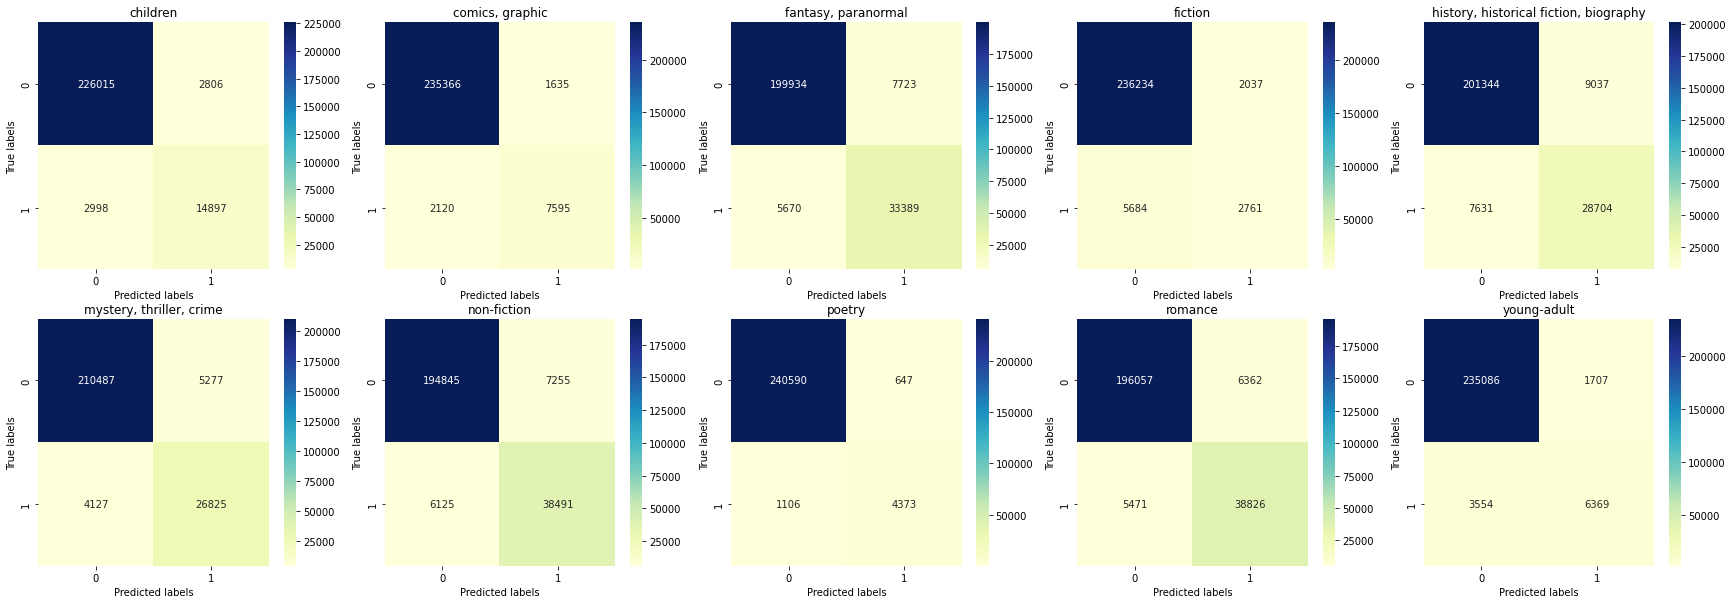

In [ ]:
#----------------- PLOT SEVERAL OF THE NUMBERS -----------------#

fig, axs = plt.subplots(2, 5, figsize=(30,10))
plot_conf_mat(axs[0,0], mccm[0], 0)
plot_conf_mat(axs[0,1], mccm[1], 1)
plot_conf_mat(axs[0,2], mccm[2], 2)
plot_conf_mat(axs[0,3], mccm[3], 3)
plot_conf_mat(axs[0,4], mccm[4], 4)
plot_conf_mat(axs[1,0], mccm[5], 5)
plot_conf_mat(axs[1,1], mccm[6], 6)
plot_conf_mat(axs[1,2], mccm[7], 7)
plot_conf_mat(axs[1,3], mccm[8], 8)
plot_conf_mat(axs[1,4], mccm[9], 9)

We can clearly see by the confusion matrices, that the model performs differently on different genres.  Will this performance change once the ensemble method is implemented? Lets get the data in a form that we can use for the ensemble method.  We will train on all 1.2 million records that have 

In [ ]:
df_all = reset_data(all_data)
# Trim and Clip
#df_all.drop(df_all[df_all.description.str.len() < 10].index, inplace=True)
df_all['trim_desc'] = df_all['description'].apply(trim_string)
df_clean = df_all[['book_id', 'trim_desc', 'genre_cleaned']]

In [ ]:
y_pred_all = lstm_model.predict(X)

In [ ]:
y_classes_all = y_pred_all.argmax(axis=-1)
y_classes_all

array([4, 2, 8, ..., 0, 4, 2])

In [ ]:
df_final = pd.DataFrame(list(zip(df_all['book_id'], y_classes_all, df_all['genre_2'], df_all['genre_cleaned'])),
               columns =['bid', 'lstm_predictions', 'true_label', 'true_genre'])


In [ ]:
df_final.head(20)

,bid,lstm_predictions,true_label,true_genre
0,1333909,4,4,"history, historical fiction, biography"
1,7327624,2,2,"fantasy, paranormal"
2,6066819,8,8,romance
3,287141,4,4,"history, historical fiction, biography"
4,6066812,2,2,"fantasy, paranormal"
5,34883016,2,8,romance
6,287149,6,6,non-fiction
7,6066814,4,4,"history, historical fiction, biography"
8,89371,6,6,non-fiction
9,89375,6,6,non-fiction
